In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import sys
import tqdm
import multiprocessing as mp
from config import *

path = result_parent_directory + os.sep + 'step4c_btms_sizing_sensitivity_wait_time'
path_no_wait = result_parent_directory + os.sep + 'step4_btms_sizing_sensitivity'

result_directory = path + os.sep + 'analysis'
os.makedirs(result_directory, exist_ok=True)
figure_directory = path + os.sep + 'figures'
os.makedirs(figure_directory, exist_ok=True)

sizing_results_path = os.path.join(path, 'sizing_results')

print('Loading results from {}'.format(sizing_results_path))
print('Loading no wait results from {}'.format(path_no_wait))
print('result_directory: {}'.format(result_directory))
print('figure_directory: {}'.format(figure_directory))

Loading results from results\advancedScenario7\step4c_btms_sizing_sensitivity_wait_time\sizing_results
Loading no wait results from results\advancedScenario7\step4_btms_sizing_sensitivity
result_directory: results\advancedScenario7\step4c_btms_sizing_sensitivity_wait_time\analysis
figure_directory: results\advancedScenario7\step4c_btms_sizing_sensitivity_wait_time\figures


In [2]:
# sort files into folders with a_cost_sizing and d_wait_cost as folder names
# a_cost_sizing is top folder, d_wait_cost is subfolder

folder_sorted_sizing = 'sorted_sizing'
for folder1 in os.listdir(sizing_results_path):
    if not folder1.startswith(folder_sorted_sizing):
        path_folder = os.path.join(sizing_results_path, folder1)
        # load a_cost_sizing and d_wait_cost from first file in dir
        file = os.listdir(path_folder)[0]
        path_file = os.path.join(path_folder, file)
        df = pd.read_csv(path_file)
        a = float(df['param: btms size, a,b_sys,b_cap,b_loan,c,d_wait_cost'][1]) * (365/12)
        d = df['param: btms size, a,b_sys,b_cap,b_loan,c,d_wait_cost'][6]
        # create folder structure
        # round a 
        path_folder_new = os.path.join(sizing_results_path, folder_sorted_sizing, 'a_' + str(round(a)))
        os.makedirs(path_folder_new, exist_ok=True)
        path_folder_new = os.path.join(path_folder_new, 'd_' + str(int(d)))
        os.makedirs(path_folder_new, exist_ok=True)
        # move files
        for file in os.listdir(path_folder):
            path_file = os.path.join(path_folder, file)
            shutil.move(path_file, path_folder_new)
        # remove empty folder
        os.rmdir(path_folder)

In [3]:
from functions.stats_sizing_function import stats_sizing_function_wait_time
# calculate stats for each charging station and save them in list and add multiindex: top-level: a_cost_sizing, second-level: d_wait_cost
stats_list = []

sizing_results_sorted = os.path.join(sizing_results_path, folder_sorted_sizing)
for folder1 in tqdm(os.listdir(sizing_results_sorted)):
    path_folder1 = os.path.join(sizing_results_sorted, folder1)
    # read a value from folder name
    a_value = float(folder1.split('_')[1])
    for folder2 in tqdm(os.listdir(path_folder1)):
        # read d value from folder name
        d_value = float(folder2.split('_')[1])
        path_folder2 = os.path.join(path_folder1, folder2)
        stats_i = []
        station_ids = []
        for file in os.listdir(path_folder2):
            station_id = int(file.split('.')[0].split('_')[2])
            station_ids.append(station_id)
            stats_i.append(stats_sizing_function_wait_time(pd.read_csv(os.path.join(path_folder2, file)), timestep))
        stats_i = pd.DataFrame(stats_i, index=station_ids)
        # make multiindex with a and d values
        stats_i.index = pd.MultiIndex.from_product([[a_value], [d_value], stats_i.index], names=['a', 'd', 'station_id'])
        # save stats in list
        stats_list.append(stats_i)
# concatenate all stats in one dataframe
stats_sizing = pd.concat(stats_list)
stats_sizing.sort_index(inplace=True)

In [4]:
index = stats_sizing.index
print('a_values: ', index.get_level_values(0).unique())
print('d_values: ', index.get_level_values(1).unique())
columns = stats_sizing.columns
print(columns)

a_values:  Float64Index([2.0, 5.0, 8.0, 10.0], dtype='float64', name='a')
d_values:  Float64Index([0.0, 1.0, 3.0, 5.0, 10.0, 15.0, 20.0, 1000000.0], dtype='float64', name='d')
Index(['btms_size', 'cost_a', 'cost_b_sys', 'cost_b_cap', 'cost_b_loan',
       'cost_b', 'cost_c', 'cost_total', 'share_cost_a', 'share_cost_b_sys',
       'share_cost_b_cap', 'share_cost_b_loan', 'share_cost_b', 'share_cost_c',
       'E_Charge', 'c_rate', 'cycles_day', 'btms_ratio', 'load_factor',
       'btms_peak_to_grid_ratio', 'grid_peak_to_charge_peak_ratio'],
      dtype='object')


this is how indexing works:
stats_sizing.loc[('a', 'd', 'station_id')]

In [5]:
stats_sizing.loc[(10.0), 'btms_size']

d          station_id
0.0        18            125.229984
           21             49.720490
           42             43.995685
           56            154.097574
           60            114.245118
                            ...    
1000000.0  1424          333.987786
           1430          257.948134
           1440          187.299125
           1442          222.452236
           1443          160.671725
Name: btms_size, Length: 1256, dtype: float64

In [6]:
stats_sizing.xs(5, level='a')['btms_size'].groupby(level ='d').describe()


,count,mean,std,min,25%,50%,75%,max
d,,,,,,,,
0.0,157.0,84.806584,56.804617,4.041627e-06,45.779881,71.916670,104.802273,300.273004
1.0,157.0,56.854397,65.232675,7.042287e-07,2.012557,39.962426,87.327429,370.734592
3.0,157.0,101.787166,68.788801,5.513413e-05,52.672680,90.249463,129.521572,409.901892
5.0,157.0,107.571229,69.396059,7.188005e-05,58.250033,95.459717,134.732569,411.026704
10.0,157.0,112.256159,68.599226,9.906921e-05,64.083345,101.729167,137.260484,412.102067
15.0,157.0,112.964238,68.385382,1.217996e-05,64.083336,101.729167,139.291667,412.103559
20.0,157.0,113.191922,68.292439,6.544850e-05,67.250002,101.729189,139.151399,412.104197
1000000.0,157.0,113.102157,68.354988,4.363456e-06,67.250003,101.729166,138.705017,412.104069


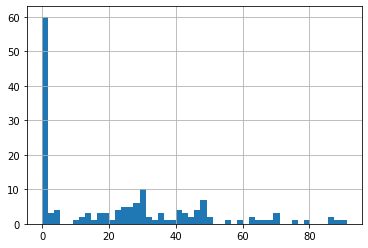

In [7]:
stats_sizing.xs(2, level='a')['btms_size'].xs(1e6,level='d').hist(bins=50)
ax = plt.gca()
#ax.set_xlim(0,)

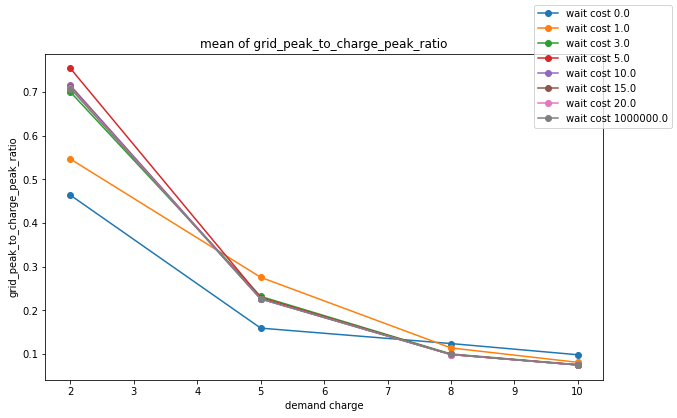

In [8]:
import matplotlib.pyplot as plt

stat_selected = 'grid_peak_to_charge_peak_ratio'

# plot results for all demand charges at every wait time cost

fig, ax = plt.subplots(figsize=(10, 6))
a = stats_sizing.index.get_level_values('a').unique()
for d in stats_sizing.index.get_level_values('d').unique():
    # plot mean for each demand charge
    y = stats_sizing.xs(d, level='d')[stat_selected].groupby('a').mean()
    ax.plot(a, y, label='wait cost ' + str(d), marker='o')
    ax.set_title('mean of ' + stat_selected )
    ax.set_xlabel('demand charge')
    ax.set_ylabel(stat_selected)
fig.legend()

In [9]:
df = stats_sizing.reset_index()
df

,a,d,station_id,btms_size,cost_a,cost_b_sys,cost_b_cap,cost_b_loan,cost_b,cost_c,...,share_cost_b_loan,share_cost_b,share_cost_c,E_Charge,c_rate,cycles_day,btms_ratio,load_factor,btms_peak_to_grid_ratio,grid_peak_to_charge_peak_ratio
0,2.0,0.0,18,32.833335,19.726027,1.064782e+01,8.938558e-01,3.607370e-01,1.154167e+01,6.937481e-01,...,1.128663e-02,3.611123e-01,2.170578e-02,843.541667,7.500000,1.000000,3.892319e-02,0.118158,8.208333e-01,0.500000
1,2.0,0.0,21,0.000037,19.726027,3.502189e-07,2.408299e-07,9.719271e-08,5.910488e-07,1.871006e-07,...,4.927130e-09,2.996289e-08,9.484959e-09,1149.916667,0.217736,0.237770,7.691584e-09,0.160471,2.699815e-08,1.000000
2,2.0,0.0,42,32.142861,7.045010,8.339116e+00,8.753502e-01,3.532686e-01,9.214466e+00,6.806723e-01,...,2.085393e-02,5.439425e-01,4.018101e-02,317.916667,5.999999,1.000000,1.011047e-01,0.126021,1.800000e+00,0.357143
3,2.0,0.0,56,59.536058,14.032901,1.671579e+01,2.053023e+00,8.285469e-01,1.876882e+01,1.593721e+00,...,2.408886e-02,5.456775e-01,4.633524e-02,388.208333,6.493257,1.266620,1.942503e-01,0.078558,1.811397e+00,0.355695
4,2.0,0.0,60,45.206370,1.693927,1.185802e+01,1.230815e+00,4.967251e-01,1.308884e+01,9.557811e-01,...,3.156106e-02,8.316421e-01,6.072869e-02,149.541667,6.066362,1.000000,3.022995e-01,0.256001,1.064515e+01,0.085873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5019,10.0,1000000.0,1424,333.987786,17.561230,1.066228e+01,1.950637e+01,7.872265e+00,3.016865e+01,1.536132e+01,...,1.247760e-01,4.781753e-01,2.434780e-01,961.416667,0.738304,2.139791,7.433449e-01,0.855750,4.616357e+00,0.178051
5020,10.0,1000000.0,1430,257.948134,10.786007,2.452533e+01,1.621011e+01,6.541980e+00,4.073544e+01,1.254921e+01,...,1.021057e-01,6.357893e-01,1.958652e-01,677.333333,2.198863,2.309379,8.794784e-01,0.999999,1.728854e+01,0.054679
5021,10.0,1000000.0,1440,187.299125,3.234129,3.200454e+01,5.286704e+00,2.133577e+00,3.729124e+01,4.094218e+00,...,4.781704e-02,8.357594e-01,9.175830e-02,200.333333,3.951769,1.037202,9.697194e-01,1.000000,7.524165e+01,0.013116
5022,10.0,1000000.0,1442,222.452236,7.603048,1.197200e+01,1.167630e+01,4.712253e+00,2.364830e+01,9.040179e+00,...,1.169540e-01,5.869298e-01,2.243692e-01,475.833333,1.244645,1.928870,9.017474e-01,1.000000,1.197245e+01,0.077086


In [10]:
print(stats_sizing.index.get_level_values('d').unique())
print(stats_sizing.columns)

Float64Index([0.0, 1.0, 3.0, 5.0, 10.0, 15.0, 20.0, 1000000.0], dtype='float64', name='d')
Index(['btms_size', 'cost_a', 'cost_b_sys', 'cost_b_cap', 'cost_b_loan',
       'cost_b', 'cost_c', 'cost_total', 'share_cost_a', 'share_cost_b_sys',
       'share_cost_b_cap', 'share_cost_b_loan', 'share_cost_b', 'share_cost_c',
       'E_Charge', 'c_rate', 'cycles_day', 'btms_ratio', 'load_factor',
       'btms_peak_to_grid_ratio', 'grid_peak_to_charge_peak_ratio'],
      dtype='object')


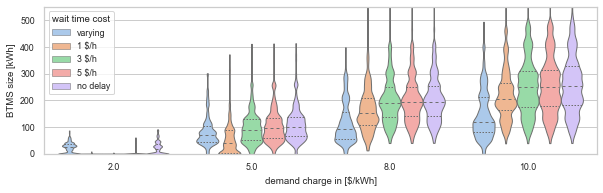

In [25]:
# make violinplots with seaborn
import seaborn as sns
import matplotlib.pyplot as plt
# select entries a 1:10, d 1:10


# remove multi index from stats_sizing
df = stats_sizing.reset_index()
# get all a <= 10 and d <= 10 or d > 20
df = df[((df['a'] <= 10) & (df['a'] >1)) & ((df['d'] < 6) | (df['d'] > 20))]

sns.set(style="whitegrid", palette="pastel", color_codes=True, font_scale = 0.8)

f, ax = plt.subplots(figsize=(1.5*plotSizeX2col, plotSizeY2col))

sns.violinplot(x="a", y="btms_size", hue="d", data=df, bw=.15, cut=.2, linewidth=1, scale='width', fontsize = 7, inner='quartiles')
pltSettings()
#sns.despine(left=True)
#ax.set_ylim(-0, 400)

# change legend
handles, labels = ax.get_legend_handles_labels()

ax.legend(handles, ['varying', '1 $/h', '3 $/h', '5 $/h', 'no delay'], title='wait time cost', loc='upper left') 
ax.set_xlabel('demand charge in [$/kWh]')
ax.set_ylabel('BTMS size [kWh]')
ax.set_ylim(0,550)

# save fig as pdf
plt.savefig(figure_directory + os.sep + 'btms_size_violinplot.pdf', bbox_inches='tight')
plt.savefig(figure_directory + os.sep + 'btms_size_violinplot.png', bbox_inches='tight', dpi=300)

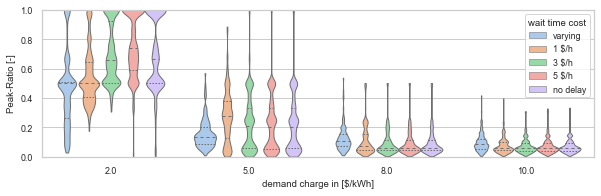

In [24]:
# make violinplots with seaborn
import seaborn as sns
import matplotlib.pyplot as plt
# select entries a 1:10, d 1:10


# remove multi index from stats_sizing
df = stats_sizing.reset_index()
# get all a <= 10 and d <= 10 or d > 20
df = df[((df['a'] <= 10) & (df['a'] >1)) & ((df['d'] < 6) | (df['d'] > 20))]

sns.set(style="whitegrid", palette="pastel", color_codes=True, font_scale = 0.8)

f, ax = plt.subplots(figsize=(1.5*plotSizeX2col, plotSizeY2col))

sns.violinplot(x="a", y="grid_peak_to_charge_peak_ratio", hue="d", data=df, bw=.15, cut=.2, linewidth=1, scale='area', fontsize = 7, inner='quartiles')
pltSettings()
#sns.despine(left=True)
#ax.set_ylim(-0, 400)

# change legend
handles, labels = ax.get_legend_handles_labels()

ax.legend(handles, ['varying', '1 $/h', '3 $/h', '5 $/h', 'no delay'], title='wait time cost', loc='upper right') 
ax.set_xlabel('demand charge in [$/kWh]')
ax.set_ylabel('Peak-Ratio [-]')
ax.set_ylim(0,1)

# save fig as pdf
plt.savefig(figure_directory + os.sep + 'peak-ratio-violinplot.pdf', bbox_inches='tight')
plt.savefig(figure_directory + os.sep + 'peak-ratio-violinplot.png', bbox_inches='tight', dpi=300)

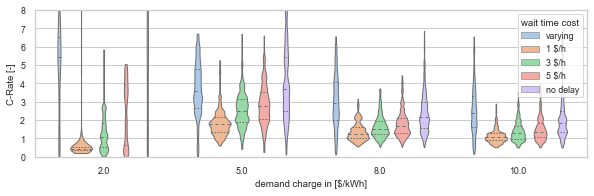

In [23]:
# make violinplots with seaborn
import seaborn as sns
import matplotlib.pyplot as plt
# select entries a 1:10, d 1:10


# remove multi index from stats_sizing
df = stats_sizing.reset_index()
# get all a <= 10 and d <= 10 or d > 20
df = df[((df['a'] <= 10) & (df['a'] >1)) & ((df['d'] < 6) | (df['d'] > 20))]

sns.set(style="whitegrid", palette="pastel", color_codes=True, font_scale = 0.8)

f, ax = plt.subplots(figsize=(1.5*plotSizeX2col, plotSizeY2col))

sns.violinplot(x="a", y="c_rate", hue="d", data=df, bw=.15, cut=.2, linewidth=1, scale='area', fontsize = 7, inner='quartiles')
pltSettings()
#sns.despine(left=True)
#ax.set_ylim(-0, 400)

# change legend
handles, labels = ax.get_legend_handles_labels()

ax.legend(handles, ['varying', '1 $/h', '3 $/h', '5 $/h', 'no delay'], title='wait time cost', loc='upper right') 
ax.set_xlabel('demand charge in [$/kWh]')
ax.set_ylabel('C-Rate [-]')
ax.set_ylim(0,8)

# save fig as pdf
plt.savefig(figure_directory + os.sep + 'c-rate-violinplot.pdf', bbox_inches='tight')
plt.savefig(figure_directory + os.sep + 'c-rate-violinplot.png', bbox_inches='tight', dpi=300)

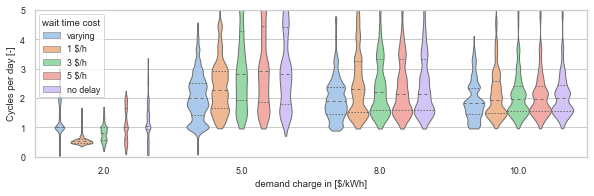

In [22]:
# make violinplots with seaborn
import seaborn as sns
import matplotlib.pyplot as plt
# select entries a 1:10, d 1:10


# remove multi index from stats_sizing
df = stats_sizing.reset_index()
# get all a <= 10 and d <= 10 or d > 20
df = df[((df['a'] <= 10) & (df['a'] >1)) & ((df['d'] < 6) | (df['d'] > 20))]

sns.set(style="whitegrid", palette="pastel", color_codes=True, font_scale = 0.8)

f, ax = plt.subplots(figsize=(1.5*plotSizeX2col, plotSizeY2col))

sns.violinplot(x="a", y="cycles_day", hue="d", data=df, bw=.15, cut=.2, linewidth=1, scale='area', fontsize = 7, inner='quartiles')
pltSettings()
#sns.despine(left=True)
#ax.set_ylim(-0, 400)

# change legend
handles, labels = ax.get_legend_handles_labels()

ax.legend(handles, ['varying', '1 $/h', '3 $/h', '5 $/h', 'no delay'], title='wait time cost', loc='upper left') 
ax.set_xlabel('demand charge in [$/kWh]')
ax.set_ylabel('Cycles per day [-]')
ax.set_ylim(0,5)

# save fig as pdf
plt.savefig(figure_directory + os.sep + 'cycles-day-violinplot.pdf', bbox_inches='tight')
plt.savefig(figure_directory + os.sep + 'cycles-day-violinplot.png', bbox_inches='tight', dpi=300)

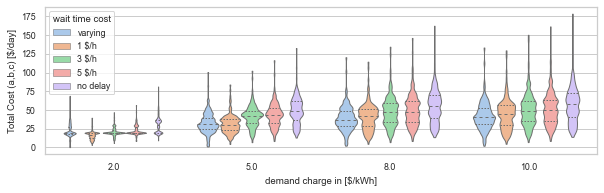

In [20]:
# make violinplots with seaborn
import seaborn as sns
import matplotlib.pyplot as plt
# select entries a 1:10, d 1:10


# remove multi index from stats_sizing
df = stats_sizing.reset_index()
# get all a <= 10 and d <= 10 or d > 20
df = df[((df['a'] <= 10) & (df['a'] >1)) & ((df['d'] < 6) | (df['d'] > 20))]

sns.set(style="whitegrid", palette="pastel", color_codes=True, font_scale = 0.8)

f, ax = plt.subplots(figsize=(1.5*plotSizeX2col, plotSizeY2col))

sns.violinplot(x="a", y="cost_total", hue="d", data=df, bw=.15, cut=.2, linewidth=1, scale='area', fontsize = 7, inner='quartiles')
pltSettings()
#sns.despine(left=True)
#ax.set_ylim(-0, 400)

# change legend
handles, labels = ax.get_legend_handles_labels()

ax.legend(handles, ['varying', '1 $/h', '3 $/h', '5 $/h', 'no delay'], title='wait time cost', loc='upper left') 
ax.set_xlabel('demand charge in [$/kWh]')
ax.set_ylabel('Total Cost (a,b,c) [$/day]')
#ax.set_ylim(0,5)

# save fig as pdf
plt.savefig(figure_directory + os.sep + 'total-cost-violinplot.pdf', bbox_inches='tight')
plt.savefig(figure_directory + os.sep + 'total-cost-violinplot.png', bbox_inches='tight', dpi=300)